- What are the initial velocities?: restart with predefined velocities
- Why are the positions negative after first iteration (MIC?) ? yes looks like it (addition of cell length gives same result as fractional)

- Why jump the coordinates from step 0 to step 1 and back from 1 to 2?
velocities seem to be ok and step 2 agrees with step 2 from python

Is agreement between curves within numerical precision?

## Simple MD without thermostat

In [40]:
run_dir = '/home/misa/git_repositories/PROFESS/test/ase_singlepoint'
p=run_profess(run_dir)

In [39]:
p.returncode

0

In [41]:
from ase import Atoms
import numpy as np
# from ase.calculators.calculator import Calculator
from ase.calculators.general import Calculator
from ase.md.verlet import VelocityVerlet
from ase import units
import profess_io as pio
import subprocess
import os


from matplotlib import pyplot as plt

In [2]:
# velocities from Bohr/aut (PROFESS) -> Ang/ (Ang sqrt(aum/eV)) (ASE)

# Bohr -> Ang = length_in_Bohr*units.Bohr
# aut -> Ang sqrt(aum/eV)
aut2fs = 2.41888433e-2 # go from aut -> fs
aut2aset = aut2fs*units.fs # from aut -> aset (ase time unit)

au_vel2ase_vel = units.Bohr/aut2aset # conversion of velocities in a.u. to native ase units

In [3]:
au_vel2ase_vel

222.71803270527124

In [4]:
def initialize_atoms(pos_file, vel_file, cell_param):
    """
    generate atoms object with:
        - correct positions
        - cell paramters
        - set initial velocities
    set calculator
    """
    positions = pio.parse_ion_file(pos_file)
#     positions = shift_atoms(positions)

            
    velocities = np.array(pio.parse_velocity_file(vel_file))*au_vel2ase_vel
    
    atoms = Atoms('Al4', scaled_positions = positions, cell = cell_param, pbc = True)
    atoms.set_velocities(velocities)
    return(atoms)
    
def shift_atoms(positions, length=3.97):
    positions_shifted = []
    for atom in positions:
        atom_shifted = []
        for c in atom:
            if c < 0:
                new_c = c + length
            else:
                new_c = c
            atom_shifted.append(new_c)
        positions_shifted.append(atom_shifted)
    return(positions_shifted)
    
class OFDFT_calculator(Calculator):
    name = 'OFDFT_calculator'
    implemented_properties = ['forces']

    def __init__(self, run_dir, for_file, atoms):
        self.forces = np.array(pio.parse_force_file(for_file))
#         self.nAtoms = atoms.get_number_of_atoms()
        self.atoms = atoms.copy()
        self.run_dir = run_dir
        
    def run_profess(self):
        os.chdir(run_dir)
        p = subprocess.run(['/home/misa/git_repositories/PROFESS/PROFESS', 'sp'])
        return(p)

    def get_forces(self, atoms=None):
        # write new .ion file
        cell_par = self.atoms.get_cell()
        atom_types = self.atoms.get_chemical_symbols()
        positions = self.atoms.get_positions()
        pos_type = 'CART'
        pp = 'al_HC.lda.recpot'
        new_ion = pio.generate_ion_file(cell_par, atom_types, positions, pos_type, pp)
        pio.write_file(self.run_dir+'sp_ase.ion', new_ion)
        # call profess
        completed_p = self.run_profess()
        # read forces
        self.forces = pio.parse_force_file(self.run_dir + '/sp.force.out')
        return(self.forces)
    
#     def calculate(self, atoms=None, properties=['energy'],
#               system_changes=None):
#         """Do the calculation.

#         properties: list of str
#             List of what needs to be calculated.  Can be any combination
#             of 'energy', 'forces', 'stress', 'dipole', 'charges', 'magmom'
#             and 'magmoms'.
#         system_changes: list of str
#             List of what has changed since last calculation.  Can be
#             any combination of these six: 'positions', 'numbers', 'cell',
#             'pbc', 'initial_charges' and 'initial_magmoms'.

#         Subclasses need to implement this, but can ignore properties
#         and system_changes if they want.  Calculated properties should
#         be inserted into results dictionary like shown in this dummy
#         example::

#             self.results = {'energy': 0.0,
#                             'forces': np.zeros((len(atoms), 3)),
#                             'stress': np.zeros(6),
#                             'dipole': np.zeros(3),
#                             'charges': np.zeros(len(atoms)),
#                             'magmom': 0.0,
#                             'magmoms': np.zeros(len(atoms))}

#         The subclass implementation should first call this
#         implementation to set the atoms attribute and create any missing
#         directories.
#         """

#         if atoms is not None:
#             self.atoms = atoms.copy()
#         if not os.path.isdir(self._directory):
#             os.makedirs(self._directory)

#         if  'forces' in properties:
#             return self.forces


In [5]:
# atom positions are automatically updated?


In [17]:
pos_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step0.dat'
vel_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step0.dat'
for_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/force_step0.dat'
cell_param = [[3.97, 0, 0], [0, 3.97, 0], [0, 0, 3.97]]

work_dir = '/home/misa/git_repositories/PROFESS/test/MD_NVE/sp_ase/'

save_pos = []
save_vel = []

atoms = initialize_atoms(pos_file, vel_file, cell_param)
for n in range(0, 21):
    atoms.set_calculator(OFDFT_calculator(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/force_step{n}.dat', atoms))
    # We want to run MD with constant energy using the VelocityVerlet algorithm.
    dyn = VelocityVerlet(atoms, 1*units.fs)  # 1 fs time step.
    # run only for one step
    f=dyn.run(1)
    
    save_pos.append(atoms.get_positions())
    save_vel.append(atoms.get_velocities())

In [25]:
atoms.get_cell()

array([[3.97, 0.  , 0.  ],
       [0.  , 3.97, 0.  ],
       [0.  , 0.  , 3.97]])

In [18]:
atoms.get_chemical_symbols()
# atoms.get_positions()

['Al', 'Al', 'Al', 'Al']

#### compare positions

In [19]:
# monitor change of profess structures

def get_coord_atom(structure_array, num_atom, name_coord):
    coord = []
    for s in structure_array:
        coord.append(s[num_atom][name_coord])
    return(coord)

structure_array = []
for pf in range(1, 21):
    structure_array.append(pio.parse_ion_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step{pf}.dat'))

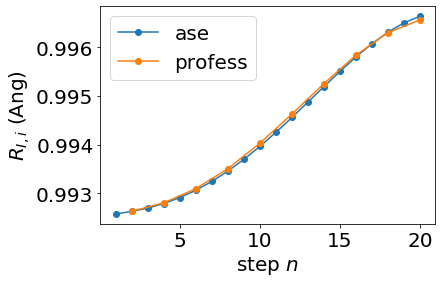

In [22]:
num_atom = 0
num_coord = 1
num_atom = 0
num_coord = 0
positions_ase = get_coord_atom(save_pos, num_atom, num_coord)
positions_profess = get_coord_atom(structure_array, num_atom, num_coord)
step = np.arange(1, 21)
fig, ax = plt.subplots(1,1)
plt.rcParams['font.size'] = 20
ax.plot(step, positions_ase[:-1], '-o', label = 'ase')
ax.plot(step[1::2], np.array(positions_profess)[1::2]*3.97, '-o', label = 'profess')
# ax.plot(step[1:], np.array(positions_profess)[1:]*3.97, '-o', label = 'profess')


ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$R_{I, i}$ (Ang)')
ax.legend()

#### compare velocities

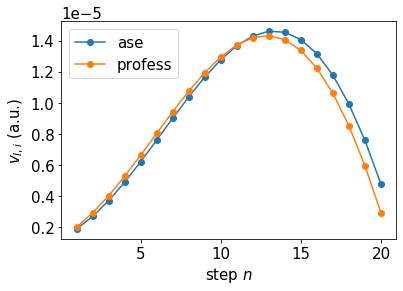

In [24]:
# get velocities from profess
vel_array = []
for pf in range(1, 21):
    vel_array.append(pio.parse_velocity_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step{pf}.dat'))

num_atom = 0
num_coord = 0
num_atom = 0
num_coord = 0
velocities_ase = get_coord_atom(np.array(save_vel)/au_vel2ase_vel, num_atom, num_coord)
velocities_profess = get_coord_atom(vel_array, num_atom, num_coord)

step = np.arange(1, 21)

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,1)

ax.plot(step, velocities_ase[:-1], '-o', label = 'ase')
ax.plot(step, velocities_profess, '-o', label = 'profess')

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$v_{I,i}$ (a.u.)')
ax.legend()

files for ofdft:
- job.inpt (stays the same during CPMD)
- job.ion (structure: update position, lattice vectors?)
- density (update from CPMD)
- al.lda.recpot (pseudopotentials: stay the same during CPMD)

Which code to do APDFT calculations? (must support crystal structures)
Are local ofdft pseudopotentials compatible with other non-local pseudopotentials?

How to do MD runs in OFDFT for comparison?

How to run NVE, What is NVT coupled with Nose-Hoover?
Why are the positions negative, so close togethcer and different from initial structure?



- get forces, velocities from ofdft during python runtime
- propagate nuclei


            